### Agente con consultas a una Base de Datos

Definimos el LLM

In [22]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os

load_dotenv()
openai_model = os.getenv("LLM_MODEL", "gpt-o4-mini")

# Crear una instancia del modelo ChatOpenAI
llm = ChatOpenAI(model= openai_model, temperature=0.5)

Hacemos la conexion con la base de datos

In [23]:
from langchain_community.utilities import SQLDatabase

username = os.getenv("POSTGRES_USER")
password = os.getenv("POSTGRES_PASSWORD")
host = os.getenv("POSTGRES_HOST", "localhost")  # Default to localhost
port = os.getenv("POSTGRES_PORT", "5432")  # Default PostgreSQL port
database = os.getenv("POSTGRES_DB", "mydatabase")  # Default database name

print(f"Connecting to database {database} at {host}:{port} as user {username}")

connection_uri = f"postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}"

dbEngine = SQLDatabase.from_uri(connection_uri)
print(dbEngine.dialect)
print(dbEngine.get_usable_table_names())

Connecting to database product_marketing at localhost:5432 as user user
postgresql
['caracteristica', 'categoria', 'imagen', 'lista', 'oferta_articulo', 'precio', 'producto', 'promocion', 'tipo_caracteristica', 'variante']


Usamos las herramientas proveidas por SQLDatabaseToolkit para listar las tablas

In [24]:
from langchain_core.tools import tool

def list_tables():
    """List all tables in the database."""
    return dbEngine.get_usable_table_names()

def get_schema():
    """Get the schema of the database."""
    return dbEngine.get_table_info()
    

list_tables_result = list_tables()
tables_schema = get_schema()

print(list_tables_result)
print(tables_schema)

['caracteristica', 'categoria', 'imagen', 'lista', 'oferta_articulo', 'precio', 'producto', 'promocion', 'tipo_caracteristica', 'variante']

CREATE TABLE caracteristica (
	id UUID DEFAULT uuid_generate_v4() NOT NULL, 
	variante_id UUID, 
	tipo_id UUID, 
	valor VARCHAR NOT NULL, 
	CONSTRAINT caracteristica_pkey PRIMARY KEY (id), 
	CONSTRAINT fk_caracteristica_tipo FOREIGN KEY(tipo_id) REFERENCES tipo_caracteristica (id), 
	CONSTRAINT fk_caracteristica_variante FOREIGN KEY(variante_id) REFERENCES variante (id)
)

/*
3 rows from caracteristica table:
id	variante_id	tipo_id	valor
c59c3d05-2400-4a1e-9791-08872a425899	933aa1f5-c3fc-44da-8140-672214bd0f0f	cc3481e5-44da-44a7-b19f-60ef46f5dc4d	16
5e89d418-bc4c-4a26-a0e9-5e883c75c577	b90ff189-ff3e-4b2e-9f6f-401077b8b9b5	cc3481e5-44da-44a7-b19f-60ef46f5dc4d	32
ca4a25e0-5b59-434e-b92a-3a6f3378fae4	e7448673-36d6-4175-b941-9307498be39c	755cd3e8-3bdd-4b7c-ad69-001bffb15114	blanco
*/


CREATE TABLE categoria (
	id UUID DEFAULT uuid_generate_v4() NOT N

Definimos el estado el cual será mutado por los nodos

In [25]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, AnyMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    """State of the agent."""
    last_question: str
    last_query: str
    last_query_result: str 
    
    summary: str
    messages: Annotated[Sequence[BaseMessage], add_messages]

Definimos la herramienta Query a BD

In [26]:
from langchain_core.messages import  SystemMessage, AIMessage, FunctionMessage, HumanMessage, RemoveMessage
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool

@tool(return_direct=True)
def query_call ():
    """Just a call to the query tool."""
    
tools = [query_call]

Definimos los Nodos

In [27]:
import ast, json, re

def agent(state: AgentState):
    """
    El agente determina si se necesita usar la herramienta de query o responde con la info actual.
    Construye una lista de mensajes para el LLM en vez de un solo prompt.
    """
    messages = []
    question = state.get("messages")[-1].content
    last_question = state.get("last_question", "")
    last_query_result = state.get("last_query_result", "")
    last_query = state.get("last_query", "")

    # Mensaje de sistema base
    base_sys_msg = (
        "Eres un agente de marketing especializado en ofrecer productos y responder preguntas sobre caracteristicas,precios, categorias, variantes y promociones u ofertas. "
        "Cuentas con una herramienta que te permite consultar a la base de datos de productos para responder preguntas del cliente. "
        "Se te presentará con una pregunta la cual debes llamar a la herramienta en caso que el usuario pida "
        "Si el cliente menciona que desea comprar el producto menciona que puede visitar la tienda o el sitio web para realizar la compra. "
        "En caso que la pregunta sea una confirmacion o sea evidente que falte contexto usa la herramienta. "
        "En caso que la pregunta no sea sobre productos, promociones, precios o caracteristicas , responde amigable y brevemente sin usar la herramienta. "
        "En caso que sí se necesita usar la herramienta, no pidas autorización al usuario, simplemente llama a la herramienta de consulta."
    )
    messages.append(SystemMessage(content=base_sys_msg))

    # Si hay resultado de query previo, añade contexto relevante
    if last_question:
        messages.append(SystemMessage(content="Usa la respuesta del query anterior y el resumen actual para responder si es posible."))
        messages.append(SystemMessage(content=f"Pregunta anterior: {last_question}"))
        messages.append(SystemMessage(content=f"Anterior query: {last_query}"))
        messages.append(SystemMessage(content=f"Resultado del query: {last_query_result}"))
        messages.append(SystemMessage(content="Si el sql query anterior no cubrió la pregunta del usuario, usa la herramienta para hacer un nuevo query."))
    else:
        messages.append(SystemMessage(content="Si necesitas información para la pregunta usa la herramienta."))

    # Añade la pregunta del usuario
    messages.append(HumanMessage(content=question))

    model = llm.bind_tools(tools)
    response = model.invoke(messages)
    
    result = {
        "response": response.content
    }
    
    response.content = json.dumps(result, ensure_ascii=False)
    
    return {"messages": [response]}


def needs_reformulation(current_question, last_question):
    # If the current question is a greeting or generic, treat as new topic
    generic_starts = ["ofreces", "ofrece", "ofrecen", "puedes mostrarme", "hola", "buenos dias", "productos", "cosas", "promociones", "articulos"]
    # Check if any generic word appears anywhere in the question (not just at the start)
    if any(g in current_question.lower() for g in generic_starts):
        return False
    # If the current question is a follow-up (e.g., has "y", "además", etc.), reformulate
    follow_ups = ["y", "además", "con", "sin", "de",     "otra vez", "opciones", "variantes", "caracteristicas", "precio", "promocion", "especificaciones"]
    if any(g in current_question.lower() for g in follow_ups):
        return False
    # If the last question is empty, don't reformulate
    if not last_question:
        return False
    # Default: reformulate
    return True

def reformulate_question(state: AgentState):
    """
    Antes de generar un query, se reformula la pregunta del usuario en base a la anterior pregunta, resumen y query.
    aqui se guarda la pregunta como ultima pregunta
    """
    messages = state.get("messages", [])
    
    last_question = state.get("last_question", "")
    last_query = state.get("last_query", "")
    last_response = messages[-4].content if len(messages) >= 4 and hasattr(messages[-4], "content") else ""
    current_question = messages[-3].content if len(messages) >= 3 and hasattr(messages[-3], "content") else ""
    summary = state.get("summary", "")
    
    if not needs_reformulation(current_question, last_question):
        return {"last_question": current_question, "messages": [HumanMessage(content=current_question)]}

    # Build message list for LLM: last question, last response, last query
    reformulation_messages = []
    if last_question:
        reformulation_messages.append(HumanMessage(content=f"Pregunta anterior: {last_question}"))
    if last_response:
        reformulation_messages.append(AIMessage(content=f"Respuesta anterior: {last_response}"))
    if last_query:
        reformulation_messages.append(SystemMessage(content=f"Query anterior: {last_query}"))

    # If not enough recent context, add summary
    if len(reformulation_messages) < 2 and summary:
        reformulation_messages.append(SystemMessage(content=f"Resumen de la conversación: {summary}"))

    prompt = (
        "Reformula la siguiente pregunta del usuario de manera breve,concisa y sin acentos para consultar a nuestra base de datos de productos "
        "los parametros de reformulacion tienen peso en el orden de importancia: "
        "1. anterior respuesta del llm, 2. anterior pregunta del usuario, 3. query anterior, 4. Resumen de la conversación.\n"
        "No tomar en cuenta la respuesta anterior o pregunta anterior si no es relevante para la pregunta actual. "
        "Si no hay suficiente contexto reciente, usa el resumen."
    )
    reformulation_messages.append(SystemMessage(content=prompt))
    
    reformulation_messages.append(HumanMessage(content=current_question))
    reformulated = llm.invoke(reformulation_messages)
        
    return {"last_question": reformulated.content ,"messages": [reformulated]}

class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


def generate_query(state):
    """" Genera un query SQL a partir de una pregunta del usuario y el schema de la base de datos. """
    question = state.get("last_question", "")
    
    schema_message = SystemMessage(content=tables_schema)
    generate_query_system_prompt = f"""
    Dada las tablas de la base de datos, solo usa las disponibles.
    Se proveera una pregunta de entrada, crea una consulta {dbEngine.dialect} sintácticamente correcta para ayudar a encontrar la respuesta. 
    Puedes ordenar los resultados por una columna relevante para devolver los ejemplos más interesantes de la base de datos.

    Al devolver cualquier precio solo pide con concepto "precio consumidor" a menos que se especifique lo contrario.
    No uses la descripcion de variante para buscar caraceristicas, usa la tabla caraceristica y tipo_caracteristica para buscar las caracteristicas de variantes.
    En caso que se consulte por las variantes, caracteristicas o especificaciones de un producto, devuelve solo el id del producto, nombre del producto, descripcion de variante y caracteristicas.
    En caso que se consulte por un producto con cierta caracteristica, busca la variante de ese producto que tenga el valor de caracteristica pedido y devuelve el id de variante, nombre del producto, descripcion de variante, caracteristicas y precios.
    
    En caso de consulta por todos los productos,devuelve los productos con id, nombre, descripcion.
    En caso que se consulte por el precio de una promocion o solo una promocion, devuelve la promocion entera estrictamente con ID, la variante relacionada a traves de oferta_articulo y el nombre de producto, no devuelvas las ids de variante ni producto.
    En caso que se consulte por promociones, devuelve las promociones enteras con ID y con las variantes relacionadas a traves de la tabla intermedia oferta_articulo, ademas devuelve el nombre del producto, no devuelvas las ids de variante ni producto.
    En caso de que se consulte por categorias, devuelve la categoria con sus productos y variantes.

    Presta atención a usar solo los nombres de columnas que aparecen en la descripción del esquema.
    Ten cuidado de no consultar columnas que no existen. Además, asegúrate de saber qué columna pertenece a qué tabla.
    """
    sys_message = SystemMessage(content=generate_query_system_prompt)
    
    question_message = HumanMessage(content=question)
    prompt_messages = [schema_message, sys_message, question_message]
    
    structured_llm = llm.with_structured_output(QueryOutput)
    response = structured_llm.invoke(prompt_messages)
    
    query = response.get("query", "")
    query_message = AIMessage(content=query)
    return {"last_query": query, "messages": [query_message]}

def run_query(state: AgentState):
    """Execute SQL query."""
    messages = state.get("messages", [])
    query = state.get("last_query", "")
    
    execute_query_tool = QuerySQLDatabaseTool(db=dbEngine)

    result = execute_query_tool.invoke(query)
    result_message = FunctionMessage(name="Sql_query", content=result)
    return {"last_query_result": result, "messages": [result_message]}

class InterestOutput(TypedDict):
    """Formato para el resultado de deteccion de interes"""

    interest: Annotated[str, ..., "A table name of the type of interest (e.g., 'producto', 'variante', 'categoria', 'promocion')"]
    
def detect_interest(state: AgentState):
    """" Detecta el tipo de elemento del que se habla, en caso que sea solo un elemento entre:
    producto, variante, categoria o promocion devuelve un mensaje con el formato: interest: <tipo> id: <id>"""
    
    question_message = HumanMessage(content=state.get("last_question", ""))
    last_query_message = AIMessage(content=state.get("last_query", ""))
    last_query_result = state.get("last_query_result", "")
    last_query_result_message = FunctionMessage(name="Sql_query", content=last_query_result)
    # Para pillar el interes buscamos ids unicos, si solo hay uno es interes
    # Regex para extraer UUIDs
    uuid_regex = r"UUID\('([a-f0-9\-]{36})'\)"
    ids = re.findall(uuid_regex, str(last_query_result))
    unique_ids = set(ids)

    # Si solo hay un id único, lo consideramos interés
    element_id = ""
    if len(unique_ids) == 1 and len(ids) > 0:
        element_id = list(unique_ids)[0]
    else:
        element_id = ""
    
    # si hay mas de un id, no se puede determinar interes
    if not element_id:
        result = {"interest": "", "element_id": ""}
        return {"messages": [AIMessage(content=json.dumps(result, ensure_ascii=False))]}
    
    
    prompt = """Detecta el tipo de elemento del que se habla, entre las tablas: producto, variante, categoria o promocion.
    Si se pregunta por las caraceristicas de un producto, devuelve 'producto'.
    Si se pregunta por las variantes disponibles de un producto, devuelve 'producto'.
    Si se pregunta por las caracteristicas o precio, especificamente de una variante especifica de producto, devuelve 'variante'."""
    sys_message = SystemMessage(content=prompt)
    messages_list = [question_message, last_query_message, last_query_result_message ,sys_message]
    
    structured_llm = llm.with_structured_output(InterestOutput)
    response = structured_llm.invoke(messages_list)
    
    interest = response.get("interest", "")
    result = {"interest": interest, "element_id": element_id}
    
    response_message = AIMessage(content=json.dumps(result, ensure_ascii=False))
    
    return{"messages": [response_message]}

def generate_response(state):
    """Generate a response based on the last query result and the summary."""
    
    interest = ""
    element_id = ""
    
    last_message = state.get("messages")[-1]
    
    content = last_message.content
    if isinstance(content, dict):
        if "interest" in content and "element_id" in content:
            interest = content["interest"]
            element_id = content["element_id"]
           
    elif isinstance(content, str):
        # Intenta parsear si es un string con formato dict
        parsed = ast.literal_eval(content)
        if isinstance(parsed, dict) and "interest" in parsed and "element_id" in parsed:
            interest = parsed["interest"]
            element_id = parsed["element_id"]

        
    question = state.get("last_question", "")
    last_query_result = state.get("last_query_result", "")
    
    prompt_message_list = []
    
    if(last_query_result):
        prompt_message_list.append(FunctionMessage(content=last_query_result, name="Sql_query"))
        prompt = """Actua como agente de marketing, 
        nunca respondas con ids, en caso que se consulte por promocion no modifiques la respuesta de ninguna manera
        usa unicamente el resultado de query para responder la pregunta:"""
    else:
        prompt = """No se obtuvo un resultado de query, responde a la pregunta unicamente ofreciendo realizar otra busqueda con diferentes valores del parametro consultado o generalizar la busqueda."""
    
    prompt_message_list.append(SystemMessage(content=prompt)) 
    prompt_message_list.append(HumanMessage(content=question))
    
    response = llm.invoke(prompt_message_list)
    
    result = {
        "interest": interest,
        "element_id": element_id,
        "response": response.content
    }

    # Devuelve como mensaje para el grafo
    return {"messages": [AIMessage(content=json.dumps(result, ensure_ascii=False))]}

def summarize(state: AgentState):
    """Summarize the conversation."""
    messages = state.get("messages", [])
    summary = state.get("summary", "")
    
    if summary:
        prompt = f"Este es el resumen actual de la conversación:\n{summary}\n\nExpande el resumen incluyendo los puntos clave y las preguntas realizadas en 3 oraciones, sin incluir respuestas o resultados de consultas SQL."
    else: 
        prompt = "Resume la conversación pasada de manera concisa y clara, incluyendo los puntos clave y las preguntas realizadas en 3 oraciones, sin incluir respuestas o resultados de consultas SQL."
        
    summary_message = HumanMessage(content=prompt)    
    summary_response = llm.invoke(messages + [summary_message]) # type: ignore
    new_summary = summary_response.content
    
    delete_messages = [RemoveMessage(id=m.id) for m in messages][:-1]
    
    return {"summary": new_summary, "messages": delete_messages}

Hacemos una arista condicional

In [28]:
from langgraph.graph import END
from typing import Literal

max_messages_before_summary = 10

def summarize_condition(state: AgentState) -> Literal["summarize", END]:
    messages = state.get("messages", [])
    if len(messages) > max_messages_before_summary:
        return "summarize"
    return END

Checkpointer en sqlite

In [29]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
from pathlib import Path

base_dir = Path.cwd().parent
db_path = base_dir / "Databases/checkpoints.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
memory = SqliteSaver(conn)

Construimos el grafo

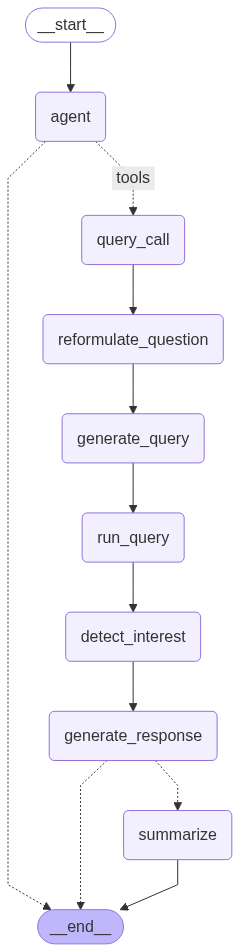

In [30]:
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import ToolNode, tools_condition

query_call_node = ToolNode([query_call])

builder = StateGraph(AgentState)

builder.add_node("agent", agent)
builder.add_node("query_call", query_call_node)
builder.add_node("reformulate_question", reformulate_question)
builder.add_node("generate_query", generate_query)
builder.add_node("run_query", run_query)
builder.add_node("detect_interest", detect_interest)
builder.add_node("generate_response", generate_response)
builder.add_node("summarize", summarize)

builder.add_edge(START, "agent")
builder.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "query_call",
        END: END
    }
)
builder.add_edge("query_call", "reformulate_question")
builder.add_edge("reformulate_question", "generate_query")
builder.add_edge("generate_query", "run_query")
builder.add_edge("run_query", "detect_interest")
builder.add_edge("detect_interest", "generate_response")
builder.add_conditional_edges(
    "generate_response",
    summarize_condition,
    {
        "summarize": "summarize",
        END: END
    }
)
builder.add_edge("summarize", END)

agent = builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

Pruebas

In [31]:
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from uuid import uuid4

thread_id = str(uuid4())
config = RunnableConfig(configurable={"thread_id": thread_id})

print(f"----NUEVA CONVERSACION CREADA CON ID: {thread_id} ----")
pregunta = HumanMessage(content="que productos tienen?")

for step in agent.stream(
    {
        "messages": [pregunta],
    },
    config= config
): 
    for node, update in step.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n")


----NUEVA CONVERSACION CREADA CON ID: bcde5233-159e-4edc-940e-d4930087556f ----
Update from node agent
================================== Ai Message ==================================

{"response": ""}
Tool Calls:
  query_call (call_zLxDMFLUHdaESc98Mwxh8Ajn)
 Call ID: call_zLxDMFLUHdaESc98Mwxh8Ajn
  Args:


Update from node query_call
================================= Tool Message =================================
Name: query_call

null


Update from node reformulate_question
================================ Human Message =================================

que productos tienen?


Update from node generate_query
================================== Ai Message ==================================

SELECT id, nombre, descripcion FROM producto;


Update from node run_query
=============================== Function Message ===============================
Name: Sql_query

[(UUID('6baa5169-c2a5-4936-bf3e-0daf48d57dad'), 'Laptop Pro 15', 'Computadora con fina calidad de construccion.'), (UUID('c894

Capturar mensaje final antes de resumen

In [1211]:
config = RunnableConfig(configurable={"thread_id": thread_id})
pregunta = HumanMessage(content="que categorias de productos tienen?")

output_messages = agent.invoke({"messages": [pregunta]}, config=config)
last_message = output_messages["messages"][-1]
last_message.pretty_print()

================================== Ai Message ==================================

{"response": "Contamos con una variedad de categorías de productos, que incluyen tecnología, electrodomésticos, moda, belleza, y más. Si estás interesado en alguna categoría específica, házmelo saber y con gusto te daré más detalles."}
